In [79]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
# % get_backend()
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

from feat_to_model_eval import feat_to_model_kfold_eval, predict_from_line
from haversine import distance_from_flatiron

In [80]:
df = pd.read_csv('kc_house_data.csv')

# CRISP - DM

## Data Understanding

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [82]:
"""id and date act as names, sqft_basement does not apply to all dwellings, sqft_lot and sqft_lot15 do not correspond exactly to the dwelling. lat and long will be used in another feature."""
df = df.drop(['id', 'date', 'sqft_basement', "sqft_above", 'lat', 'long', 'sqft_lot', 'sqft_lot15'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15
0,221900.0,3,1.00,1180,1.0,NaN,0.0,3,7,1955,0.0,98178,1340
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,1951,1991.0,98125,1690
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,1933,NaN,98028,2720
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1965,0.0,98136,1360
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1987,0.0,98074,1800


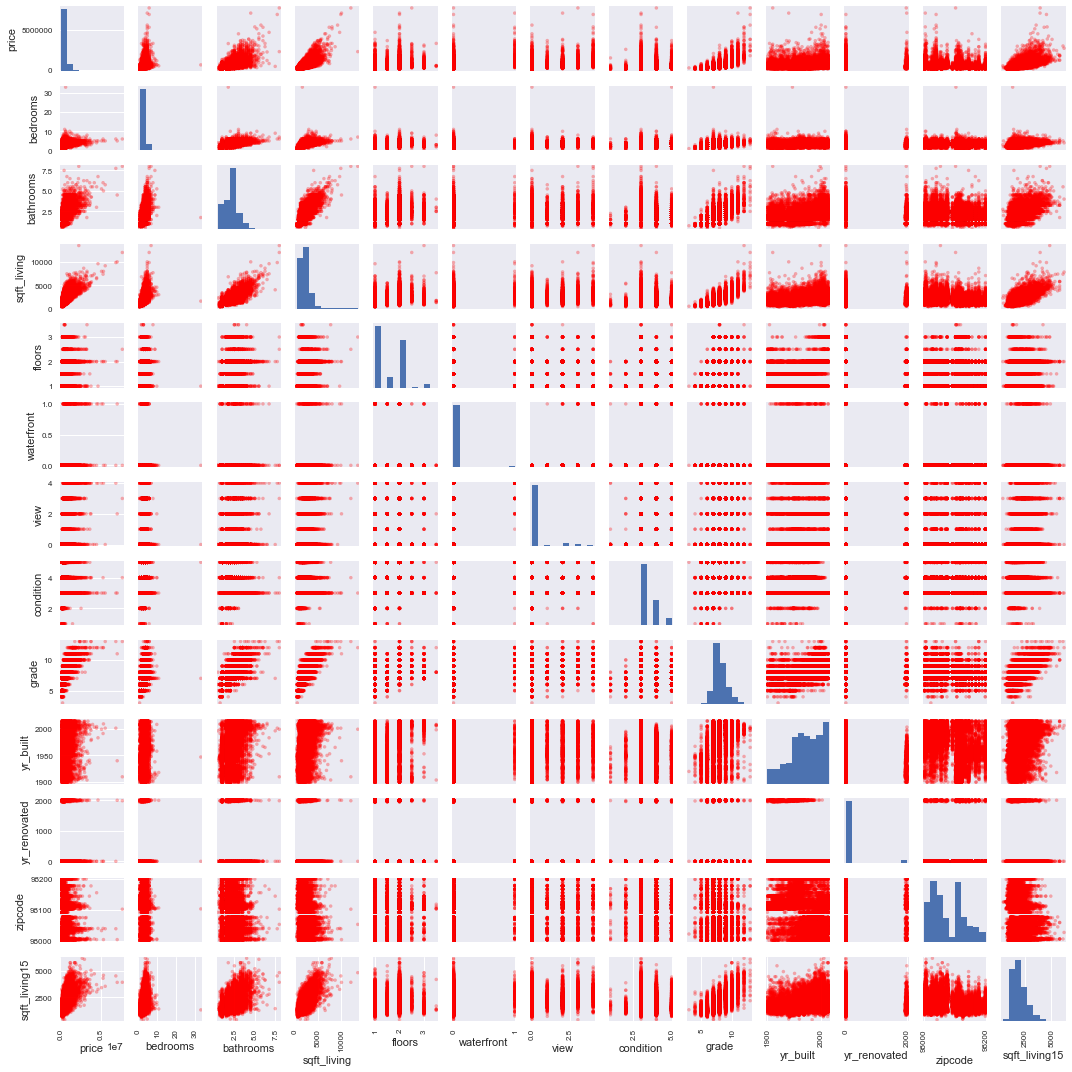

In [27]:
pd.plotting.scatter_matrix(df, figsize=(15,15), c = "red", alpha=0.3)
plt.tight_layout()
plt.show()

In [83]:
df.corr().price

price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
floors           0.256804
waterfront       0.276295
view             0.395734
condition        0.036056
grade            0.667951
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
sqft_living15    0.585241
Name: price, dtype: float64

In [84]:
"""Here are the strongest candidates; correlation over 0.5 """
temp = df[['price', 'sqft_living', 'sqft_living15', 'bathrooms', 'grade']]
temp.corr().price[1:]

sqft_living      0.701917
sqft_living15    0.585241
bathrooms        0.525906
grade            0.667951
Name: price, dtype: float64

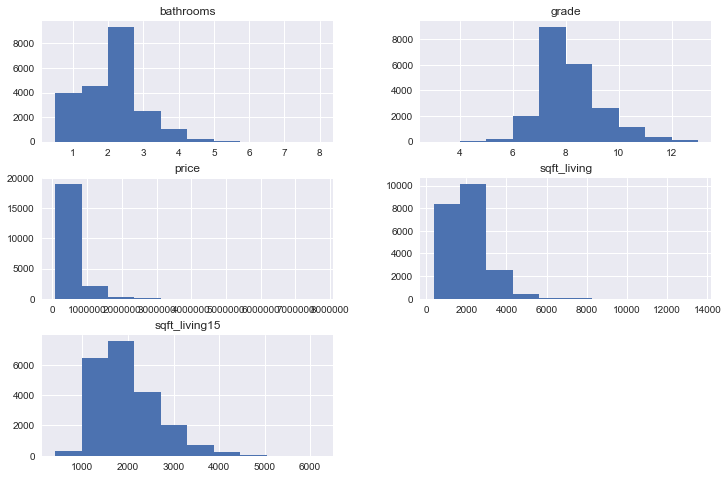

In [30]:
temp.hist(figsize=(12,8))
plt.show()

In [85]:
"""These parameters don't meet the assumptions for linear regression, so we'll scale some with log."""
log_df = pd.DataFrame([])
for col in temp:
    log_df[f'log_{col}'] = np.log(temp[col])
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_bathrooms,log_grade
0,12.309982,7.073270,7.200425,0.000000,1.945910
1,13.195614,7.851661,7.432484,0.810930,1.945910
2,12.100712,6.646391,7.908387,0.000000,1.791759
3,13.311329,7.580700,7.215240,1.098612,1.945910
4,13.142166,7.426549,7.495542,0.693147,2.079442


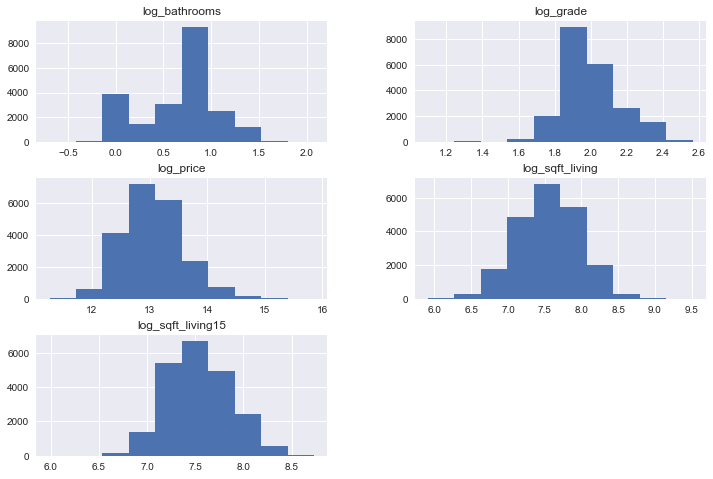

In [32]:
"""All of these distributions have improved with by taking the log, except bathrooms. This is likely because there are entries with bathrooms < 1; making their logs negative."""
log_df.hist(figsize = (12,8))
plt.show()

In [86]:
log_df.drop(['log_bathrooms'], axis = 1, inplace = True)
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_grade
0,12.309982,7.073270,7.200425,1.945910
1,13.195614,7.851661,7.432484,1.945910
2,12.100712,6.646391,7.908387,1.791759
3,13.311329,7.580700,7.215240,1.945910
4,13.142166,7.426549,7.495542,2.079442


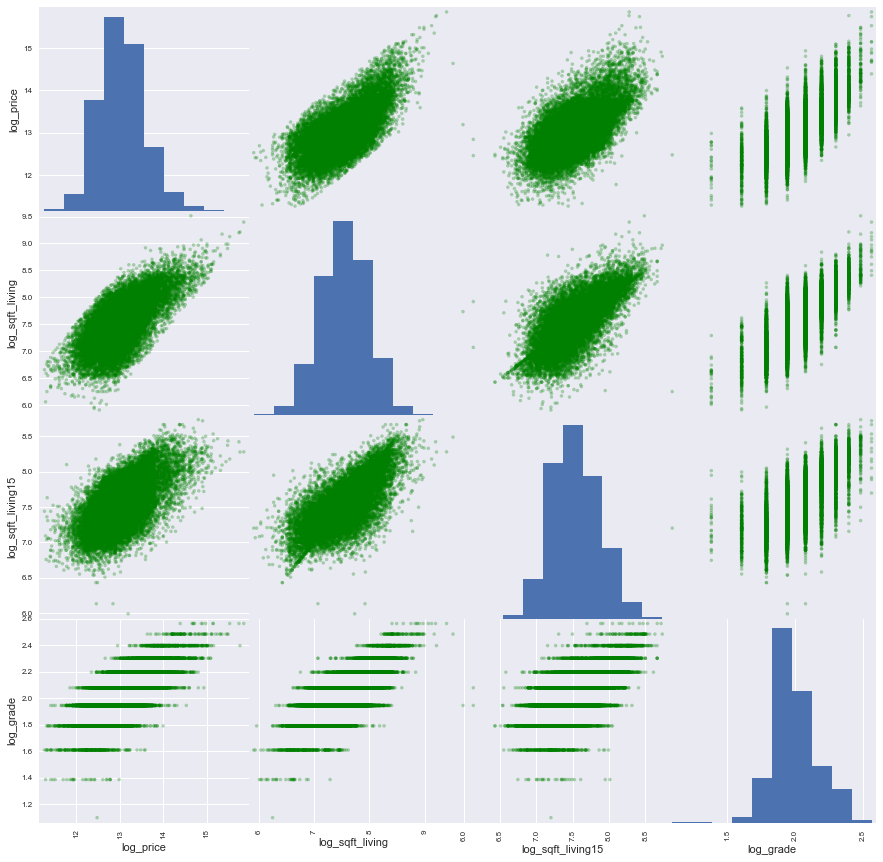

In [87]:
"""Let's see how the log_df looks as a scatter matrix."""
pd.plotting.scatter_matrix(log_df, figsize = (15,15), c = "green", alpha = 0.3)
plt.show()

In [88]:
log_df.corr().log_price

log_price            1.000000
log_sqft_living      0.674802
log_sqft_living15    0.607154
log_grade            0.693837
Name: log_price, dtype: float64

In [89]:
"""Now we add them to the dataframe"""
df = pd.concat((df, log_df), axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15,log_price,log_sqft_living,log_sqft_living15,log_grade
0,221900.0,3,1.00,1180,1.0,NaN,0.0,3,7,1955,0.0,98178,1340,12.309982,7.073270,7.200425,1.945910
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,1951,1991.0,98125,1690,13.195614,7.851661,7.432484,1.945910
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,1933,NaN,98028,2720,12.100712,6.646391,7.908387,1.791759
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1965,0.0,98136,1360,13.311329,7.580700,7.215240,1.945910
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1987,0.0,98074,1800,13.142166,7.426549,7.495542,2.079442


In [90]:
"""Now we'll convert zipcode to category."""
zip_dummies = pd.get_dummies((df.zipcode), prefix='zip')

In [91]:
zip_dummies.head()

,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
zip_dummies["log_price"] = df["log_price"].values
zip_dummies.head()

,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,log_price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,12.309982
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.195614
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.100712
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.311329
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.142166


In [93]:
"""Eliminate any zip_dummies columns with p >= 0.05"""
zip_string = zip_dummies.columns[: -1]

In [94]:
zips = "+" .join(zip_string)

In [95]:
f = "log_price~" + zips

In [96]:
model = ols(formula = f, data = zip_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     351.7
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:12:01   Log-Likelihood:                -8640.7
No. Observations:               21597   AIC:                         1.742e+04
Df Residuals:                   21527   BIC:                         1.798e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8732      0.003   4549.042      0.000      12.868      12.879
zip_98001     -0.3801      0.019    -20.031      0.000      -0.417      -0.343
zip_98002     -0.5355      0.025    -21.059      0.000      -0.585      -0.486
zip_98003     -0.3333      0.021    -15.511      0.000      -0.375      -0.291
zip_98004      1.1356      0.020     56.159      0.000       1.096       1.175
zip_98005      0.6870      0.028     24.849      0.000       0.633       0.741
zip_98006      0.6894      0.016     42.497      0.000       0.658       0.721
zip_98007      0.4132      0.030     13.702      0.000       0.354       0.472
zip_98008      0.4052      0.021     18.955      0.000       0.363       0.447
zip_98010     -0.0216      0.036     -0.604      0.546      -0.092       0.048
zip_98011      0.2011      0.026      7.830      0.000       0.151       0.251
zip_98014      0.0248      0.032      0.772      0.440      -0.038       0.088
zip_98019      0.0415      0.026      1.597      0.110      -0.009       0.093
zip_98022     -0.2686      0.024    -11.417      0.000      -0.315      -0.222
zip_98023     -0.3608      0.016    -22.260      0.000      -0.393      -0.329
zip_98024      0.2536      0.040      6.347      0.000       0.175       0.332
zip_98027      0.3794      0.018     21.326      0.000       0.344       0.414
zip_98028      0.1265      0.021      5.918      0.000       0.085       0.168
zip_98029      0.4060      0.020     20.200      0.000       0.367       0.445
zip_98030     -0.3044      0.022    -13.555      0.000      -0.348      -0.260
zip_98031     -0.2887      0.022    -13.270      0.000      -0.331      -0.246
zip_98032     -0.4750      0.032    -14.840      0.000      -0.538      -0.412
zip_98033      0.6130      0.017     35.263      0.000       0.579       0.647
zip_98034      0.2031      0.016     13.078      0.000       0.173       0.234
zip_98038     -0.1121      0.015     -7.497      0.000      -0.141      -0.083
zip_98039      1.5972      0.050     31.632      0.000       1.498       1.696
zip_98040      1.0299      0.021     48.090      0.000       0.988       1.072
zip_98042     -0.2750      0.016    -17.740      0.000      -0.305      -0.245
zip_98045      0.0423      0.024      1.749      0.080      -0.005       0.090
zip_98052      0.4622      0.015     30.516      0.000       0.432       0.492
zip_98053      0.4847      0.018     26.956      0.000       0.449       0.520
zip_98055     -0.2940      0.022    -13.391      0.000      -0.337      -0.251
zip_98056     -0.0152      0.018     -0.850      0.395      -0.050       0.020
zip_98058     -0.1503      0.017     -8.869      0.000      -0.184      -0.117
zip_98059      0.1514      0.017      9.055      0.000       0.119       0.184
zip_98065      0.2545      0.021     12.409      0.000       0.214       0.295
zi

In [97]:
#
zips_to_drop = ["log_price", "zip_98010", "zip_98014", "zip_98019", "zip_98056", "zip_98126", "zip_98133", "zip_98155", "zip_98166"]
#

In [98]:
zip_dummies = zip_dummies.drop(zips_to_drop, axis = 1)
zip_dummies.head()

,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98011,zip_98022,...,zip_98136,zip_98144,zip_98146,zip_98148,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
df = pd.concat((df, zip_dummies), axis=1)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 79 columns):
price                21597 non-null float64
bedrooms             21597 non-null int64
bathrooms            21597 non-null float64
sqft_living          21597 non-null int64
floors               21597 non-null float64
waterfront           19221 non-null float64
view                 21534 non-null float64
condition            21597 non-null int64
grade                21597 non-null int64
yr_built             21597 non-null int64
yr_renovated         17755 non-null float64
zipcode              21597 non-null int64
sqft_living15        21597 non-null int64
log_price            21597 non-null float64
log_sqft_living      21597 non-null float64
log_sqft_living15    21597 non-null float64
log_grade            21597 non-null float64
zip_98001            21597 non-null uint8
zip_98002            21597 non-null uint8
zip_98003            21597 non-null uint8
zip_98004            21597 non-

In [101]:
"""Finally, we'll partition the cleaned data set for our ultimate test."""
df, df_holdout = train_test_split(df, test_size=0.15) 

In [102]:
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240 entries, 10561 to 14613
Data columns (total 79 columns):
price                3240 non-null float64
bedrooms             3240 non-null int64
bathrooms            3240 non-null float64
sqft_living          3240 non-null int64
floors               3240 non-null float64
waterfront           2873 non-null float64
view                 3227 non-null float64
condition            3240 non-null int64
grade                3240 non-null int64
yr_built             3240 non-null int64
yr_renovated         2651 non-null float64
zipcode              3240 non-null int64
sqft_living15        3240 non-null int64
log_price            3240 non-null float64
log_sqft_living      3240 non-null float64
log_sqft_living15    3240 non-null float64
log_grade            3240 non-null float64
zip_98001            3240 non-null uint8
zip_98002            3240 non-null uint8
zip_98003            3240 non-null uint8
zip_98004            3240 non-null uint8
zip_980

In [103]:
df_holdout.to_csv("df_holdout.csv")

In [104]:
df.to_csv("df_train.csv")